Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Water Act Historic Compliance Violations

This notebook examines ECHO data using NPDES_QNCR_HISTORY, 
which reports the number of non-compliance violations in
four categories:
1) Effluent (E90) violations
2) Compliance schedule violagions,
3) Single event violations
4) Permit schedule violations

A state and congressional district must be chosen.

In [2]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



In [3]:

sql = "select FAC_STATE, NPDES_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
# print(data_location)


select FAC_STATE, NPDES_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'


In [4]:
# exporter_data = "data/echo_exporter_npdes.csv" # Where the ECHO data resides
# exporter_data = "https://stevenehansen.com/EDGI/echo_exporter_npdes.csv" # Where the ECHO data resides
# echo_data = pd.read_csv(exporter_data, usecols = list(column_mapping.keys()), dtype=column_mapping)

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)


Run this next cell, select a state, and then run the following cell.

In [6]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [7]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s NDIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 10202 NDIS facilities in NY tracked in the ECHO database.


In [22]:
my_state_facs

,FAC_STATE,NPDES_IDS,FAC_DERIVED_CD113
30,WA,WA0030074,7.0
84,WA,WAR307188,6.0
139,WA,WA0029351 WAL029351 WAU000005,8.0
367,WA,WAR002521,3.0
384,WA,WAR305691,2.0
...,...,...,...
600480,WA,WAR127195,5.0
600596,WA,WAR304506,4.0
600628,WA,WAR306236,10.0
600670,WA,WAP007438,1.0


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [8]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=0,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

In [9]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s NDIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 304 NDIS facilities in NY district 2 tracked in the ECHO database.


Next look up the compliance violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [13]:
sql = "select NPDES_ID, YEARQTR, NUME90Q, NUMCVDT, NUMSVCD, NUMPSCH" + \
    " from NPDES_QNCR_HISTORY where YEARQTR > 20100 and YEARQTR < 20200"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(sql)

qncr_data = pd.read_csv(data_location,header = 0)
qncr_data.set_index( "NPDES_ID", inplace=True)
qncr_data

,YEARQTR,NUME90Q,NUMCVDT,NUMSVCD,NUMPSCH
NPDES_ID,,,,,
AK0001058,20101,0,0,0,3
AK0001058,20102,0,0,0,3
AK0001058,20103,0,0,0,3
AK0001058,20104,0,0,0,3
AK0001058,20111,0,0,0,3
...,...,...,...,...,...
WYR320693,20162,0,0,0,0
WYR320693,20163,0,0,0,0
WYR320693,20164,0,0,0,0


In [14]:
# The NDIS_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in NPDES_QNCR_HISTORY.

my_cd_npdes = pd.DataFrame()
no_data_ids = []
for ids in my_cd_facs['NPDES_IDS']:
    for npdes_id in ids.split():
        try:
            npdes_data = qncr_data.loc[ npdes_id ]
            frames = [my_cd_npdes, npdes_data]
            my_cd_npdes = pd.concat( frames )
        except KeyError:
            no_data_ids.append( npdes_id )


In [15]:
my_cd_groups = my_cd_npdes.groupby( 'YEARQTR' )[['NUMCVDT','NUME90Q','NUMPSCH','NUMSVCD']].sum()

NUMCVDT - (Number of Compliance Schedule Violations in Quarter) A count of the number of compliance schedule violations reported in the quarter, defined by YEARQTR.

NUME90Q - (Number of E90 Violations in Quarter) A count of the number of effluent violations (E90) reported in the quarter, defined by YEARQTR.

NUMPSCH - (Number of Permit Schedule Violations in Quarter) A count of the number of permit schedule violations reported in the quarter, defined by YEARQTR.

NUMSVCD - (Number of Single Event Violations in Quarter) A count of the number of single event violations reported in the quarter, defined by PRHQRTR.

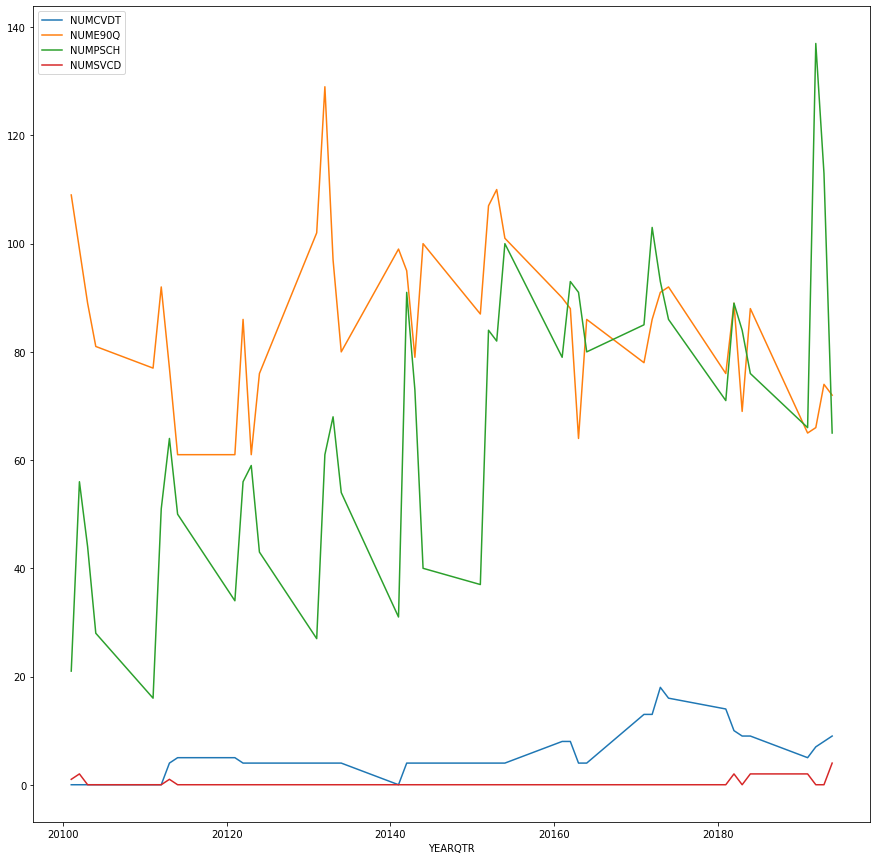

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
my_cd_groups.plot(ax=ax)

How is the number of effluent violations (NUME90Q) related to the number of permit schedule violations (NUMPSCH)?